In [264]:
import numpy
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

In [265]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'pos_25.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'neg_25.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(numpy.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = numpy.array(datasets[i])
    return datasets

In [266]:
pos_datasets = from_files_to_vectors("./Adhesin_data/25_similarity/pos/", positive=True)
neg_datasets = from_files_to_vectors("./Adhesin_data/25_similarity/neg/", positive=False)

y_pos = numpy.ones(pos_datasets[0].shape[0])
y_neg = numpy.zeros(neg_datasets[0].shape[0])

In [267]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of virulent factors and the number of not virulent factors
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('pos:', n_pos)
print('neg:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = numpy.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = numpy.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = numpy.concatenate([neg_datasets[j][i] for j in range(5)])

pos: 2700
neg: 2700
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (5400, 693)


In [268]:
# permutation
numpy.random.seed(990)

y = numpy.concatenate((y_pos, y_neg), axis=0)
c = numpy.random.permutation(numpy.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [269]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [270]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining virulent factors and not-virulent factors:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation virulent factors and not-virulent factors:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test virulent factors and not-virulent factors:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (2700, 693) (2700,)
Validation data shape: (1350, 693) (1350,)
Test data shape: (1350, 693) (1350,)

Training virulent factors and not-virulent factors: 1320 1380
Validation virulent factors and not-virulent factors: 688 662
Test virulent factors and not-virulent factors: 692 658


In [278]:
# merge train and val for the cv # test will be used for the LOUV

X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

# now i got train (75%) and test (25%)

In [279]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4050, 693) (4050,)
(1350, 693) (1350,)


In [280]:
# PCA

stdX = numpy.zeros(X_train.shape)
#stdX_val = numpy.zeros(X_val.shape)
stdX_test = numpy.zeros(X_test.shape)

means = numpy.zeros(X_train.shape[1])
std_devs = numpy.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = numpy.mean(column)
    std_devs[j] = numpy.std(column)
    stdX[:,j] = (column - means[j]) / std_devs[j]
    #stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

numpy.save('means', means)
numpy.save('std_devs', std_devs)

covariance_matrix = numpy.cov(stdX.T)

eigen_values, eigen_vectors = numpy.linalg.eig(covariance_matrix)
eigen_values = numpy.real(eigen_values)
eigen_vectors = numpy.real(eigen_vectors)

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

cumulative_variance_explained = numpy.cumsum(variance_explained)

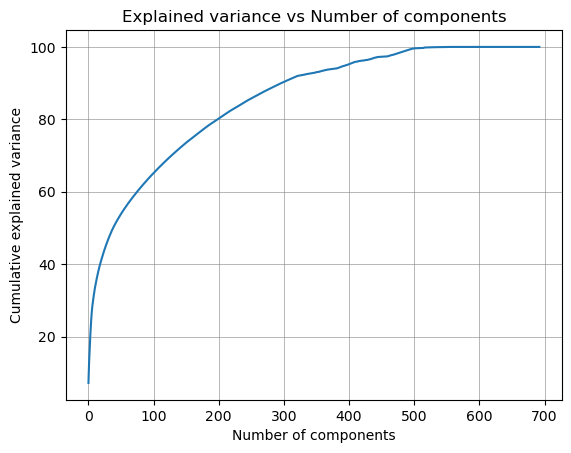

In [281]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [282]:
K = 400 # more or less like adhesin
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


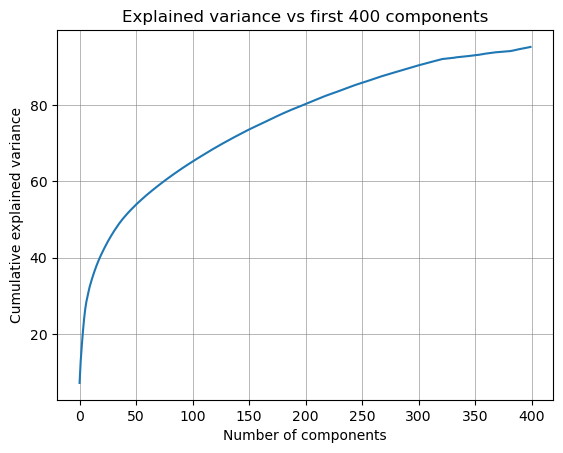

In [283]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [284]:
# Project using first K components

projection_matrix = numpy.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

numpy.save('projection_matrix', projection_matrix)

(693, 400)


In [285]:
# project matrices
X_train = stdX.dot(projection_matrix)
#X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

In [286]:
X_train.shape


(4050, 400)

In [287]:
#X_val.shape

In [288]:
X_test.shape

(1350, 400)

In [292]:
#X = np.concatenate((X_train, X_val, X_test), axis=0)
#y = np.concatenate((y_train, y_val, y_test), axis=0)
#X.shape

X = X_train
y = y_train

In [293]:
y.shape

(4050,)

In [294]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Definisci la classe della rete neurale
class NeuralNetwork:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(units=10, activation='sigmoid', input_shape=(K,)),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'mse', 'recall', 'precision'])
        return model

# Definisci il numero di fold per la cross-validation
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inizializza una lista per salvare gli score di validazione per ogni fold
val_accuracy_cv = []
val_recall_cv = []
val_precision_cv = []

# Itera attraverso i fold della cross-validation
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Inizializza e addestra la rete neurale
    nn = NeuralNetwork()
    history = nn.model.fit(
        x=X_train_fold, 
        y=y_train_fold,
        batch_size=64,
        epochs=1000,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(restore_best_weights=True, patience=20)]
    )
    
    # Valuta la rete neurale sul fold di validazione
    val_loss, val_accuracy, val_mse, val_recall, val_precision = nn.model.evaluate(X_val_fold, y_val_fold)
  
    

    
    val_accuracy_cv.append(val_accuracy)
    val_recall_cv.append(val_recall)
    val_precision_cv.append(val_precision)

# Calcola e stampa l'accuracy media dei fold di validazione
mean_val_accuracy = np.mean(val_accuracy_cv)
mean_val_recall = np.mean(val_recall_cv)
mean_val_precision = np.mean(val_precision_cv)
print("Mean Validation Accuracy:", mean_val_accuracy)
print("Mean Validation recall:", mean_val_recall)
print("Mean Validation precision:", mean_val_precision)

print("accuracy:", val_accuracy_cv)
print("recall:", val_recall_cv)
print("precision:", val_precision_cv)

Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5174 - loss: 0.7959 - mse: 0.2917 - precision: 0.5148 - recall: 0.9976 - val_accuracy: 0.5378 - val_loss: 0.6751 - val_mse: 0.2425 - val_precision: 0.5201 - val_recall: 0.9970
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5748 - loss: 0.6162 - mse: 0.2165 - precision: 0.5348 - recall: 0.9956 - val_accuracy: 0.6867 - val_loss: 0.5497 - val_mse: 0.1855 - val_precision: 0.6170 - val_recall: 0.9867
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.7656 - loss: 0.4955 - mse: 0.1607 - precision: 0.6875 - recall: 0.9831 - val_accuracy: 0.8156 - val_loss: 0.4700 - val_mse: 0.1488 - val_precision: 0.7396 - val_recall: 0.9749
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.8770 - loss: 0.4223 - mse: 0.1272 - precision: 0.8103 - recall: 0.9824 - val_accuracy: 0.8726 - val_loss: 0.4161 - val_mse: 0.1253 - val_precision: 0.8182 - val_recall: 0.9586
Epoch 5/1000
43/43 ━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.9783 - loss: 0.0948 - mse: 0.0211 - precision: 0.9824 - recall: 0.9733 - val_accuracy: 0.9222 - val_loss: 0.2301 - val_mse: 0.0644 - val_precision: 0.9156 - val_recall: 0.9305
Epoch 31/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.9759 - loss: 0.0995 - mse: 0.0231 - precision: 0.9777 - recall: 0.9731 - val_accuracy: 0.9230 - val_loss: 0.2303 - val_mse: 0.0643 - val_precision: 0.9169 - val_recall: 0.9305
Epoch 32/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9808 - loss: 0.0896 - mse: 0.0200 - precision: 0.9841 - recall: 0.9763 - val_accuracy: 0.9230 - val_loss: 0.2314 - val_mse: 0.0646 - val_precision: 0.9169 - val_recall: 0.9305
Epoch 33/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.9799 - loss: 0.0892 - mse: 0.0202 - precision: 0.9832 - recall: 0.9759 - val_accuracy: 0.9222 - val_loss: 0.2320 - val_mse: 0.0647 - val_precision: 0.9156 - val_recall: 0.9305
Epoch 34/1000
43/43 ━━━━━━━━━━━━━━

Epoch 15/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.9577 - loss: 0.1660 - mse: 0.0395 - precision: 0.9674 - recall: 0.9441 - val_accuracy: 0.9244 - val_loss: 0.2241 - val_mse: 0.0617 - val_precision: 0.9204 - val_recall: 0.9260
Epoch 16/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9584 - loss: 0.1594 - mse: 0.0385 - precision: 0.9589 - recall: 0.9577 - val_accuracy: 0.9244 - val_loss: 0.2206 - val_mse: 0.0611 - val_precision: 0.9204 - val_recall: 0.9260
Epoch 17/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.9683 - loss: 0.1434 - mse: 0.0328 - precision: 0.9710 - recall: 0.9645 - val_accuracy: 0.9259 - val_loss: 0.2177 - val_mse: 0.0606 - val_precision: 0.9219 - val_recall: 0.9275
Epoch 18/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.9646 - loss: 0.1386 - mse: 0.0324 - precision: 0.9704 - recall: 0.9600 - val_accuracy: 0.9259 - val_loss: 0.2167 - val_mse: 0.0606 - val_precision: 0.9219 - val_recall: 0.9275
Epoch 19/1000
43/43 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.9841 - loss: 0.0654 - mse: 0.0143 - precision: 0.9840 - recall: 0.9848 - val_accuracy: 0.9200 - val_loss: 0.2226 - val_mse: 0.0624 - val_precision: 0.9134 - val_recall: 0.9245
Epoch 45/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.9874 - loss: 0.0607 - mse: 0.0124 - precision: 0.9892 - recall: 0.9860 - val_accuracy: 0.9207 - val_loss: 0.2231 - val_mse: 0.0624 - val_precision: 0.9136 - val_recall: 0.9260
Epoch 46/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.9881 - loss: 0.0594 - mse: 0.0126 - precision: 0.9897 - recall: 0.9866 - val_accuracy: 0.9207 - val_loss: 0.2241 - val_mse: 0.0626 - val_precision: 0.9136 - val_recall: 0.9260
Epoch 47/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.9841 - loss: 0.0601 - mse: 0.0130 - precision: 0.9833 - recall: 0.9851 - val_accuracy: 0.9200 - val_loss: 0.2255 - val_mse: 0.0628 - val_precision: 0.9122 - val_recall: 0.9260
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 308u

Epoch 26/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.9709 - loss: 0.1069 - mse: 0.0259 - precision: 0.9734 - recall: 0.9668 - val_accuracy: 0.9119 - val_loss: 0.2105 - val_mse: 0.0628 - val_precision: 0.9130 - val_recall: 0.9090
Epoch 27/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.9755 - loss: 0.0994 - mse: 0.0233 - precision: 0.9759 - recall: 0.9731 - val_accuracy: 0.9126 - val_loss: 0.2107 - val_mse: 0.0628 - val_precision: 0.9144 - val_recall: 0.9090
Epoch 28/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9750 - loss: 0.0934 - mse: 0.0216 - precision: 0.9728 - recall: 0.9770 - val_accuracy: 0.9126 - val_loss: 0.2119 - val_mse: 0.0633 - val_precision: 0.9132 - val_recall: 0.9104
Epoch 29/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.9836 - loss: 0.0800 - mse: 0.0178 - precision: 0.9838 - recall: 0.9833 - val_accuracy: 0.9111 - val_loss: 0.2136 - val_mse: 0.0639 - val_precision: 0.9117 - val_recall: 0.9090
Epoch 30/1000
43/43 

In [126]:
val_accuracy_cv

[0.7692307829856873,
 0.8014705777168274,
 0.8125,
 0.7573529481887817,
 0.7463235259056091,
 0.7573529481887817,
 0.7389705777168274,
 0.7536764740943909,
 0.7058823704719543,
 0.7536764740943909]